In [1]:
%matplotlib inline


# Alpha CSC on simulated data


This example demonstrates alphaCSC on simulated data.



In [2]:
# Authors: Mainak Jas <mainak.jas@telecom-paristech.fr>
#          Tom Dupre La Tour <tom.duprelatour@telecom-paristech.fr>
#          Umut Simsekli <umut.simsekli@telecom-paristech.fr>
#          Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)

Let us first define the parameters of our model.


In [3]:
n_times_atom = 64  # L
n_times = 512  # T
n_atoms = 2  # K
n_trials = 100  # N

alpha = 1.2
reg = 0.1

Next, we define the parameters for alpha CSC


In [4]:
n_iter_global = 10
n_iter_optim = 50
n_iter_mcmc = 100
n_burnin_mcmc = 50

Here, we simulate the data


In [5]:
from alphacsc.simulate import simulate_data # noqa

random_state_simulate = 1
X, ds_true, Z_true = simulate_data(n_trials, n_times, n_times_atom,
                                   n_atoms, random_state_simulate)

Add some noise and corrupt some trials even with impulsive noise


In [6]:
from scipy.stats import levy_stable # noqa
from alphacsc import check_random_state # noqa

fraction_corrupted = 0.02
n_corrupted_trials = int(fraction_corrupted * n_trials)

# Add stationary noise:
rng = check_random_state(random_state_simulate)
X += 0.01 * rng.randn(*X.shape)

noise_level = 0.005
# add impulsive noise
idx_corrupted = rng.randint(0, n_trials,
                            size=n_corrupted_trials)
X[idx_corrupted] += levy_stable.rvs(alpha, 0, loc=0, scale=noise_level,
                                    size=(n_corrupted_trials, n_times),
                                    random_state=random_state_simulate)

and then alpha CSC on the same data


In [7]:
from functools import partial # noqa
from alphacsc import learn_d_z_weighted # noqa

d_hat, z_hat, Tau = learn_d_z_weighted(
    X, n_atoms, n_times_atom, reg=reg, alpha=alpha,
    solver_d_kwargs=dict(factr=100), n_iter_global=n_iter_global,
    n_iter_optim=n_iter_optim, init_tau=True,
    n_iter_mcmc=n_iter_mcmc, n_burnin_mcmc=n_burnin_mcmc,
    random_state=60, n_jobs=1, verbose=1)

..................................................Global Iter: 0	
..................................................Global Iter: 1	
..................................................Global Iter: 2	
..................................................Global Iter: 3	
..................................................Global Iter: 4	
..................................................Global Iter: 5	
..................................................Global Iter: 6	
..................................................Global Iter: 7	
..................................................Global Iter: 8	
..................................................Global Iter: 9	


Finally, let's compare the results. Now, it works even in the presence
of impulsive noise.


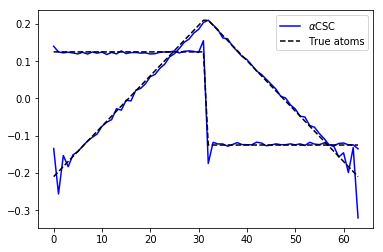

In [8]:
import matplotlib.pyplot as plt # noqa

plt.figure()
plt.plot(d_hat.T, 'b', label=r'$\alpha$CSC')
plt.plot(ds_true.T, 'k--', label='True atoms')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::2], labels[::2], loc='best')
plt.show()

We can even visualize the weights to see what time points were
downweighted by the algorithm


Text(0,0.5,'Corrupted trial')

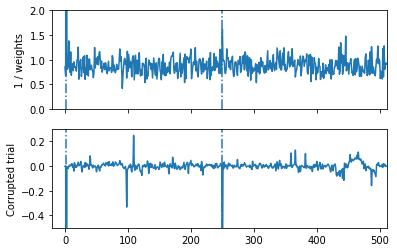

In [9]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].set_xlim([-20, n_times])
axes[0].set_ylim([0, 2])
axes[1].set_ylim([-0.5, 0.3])

for t in [2, 250]:
    axes[0].axvline(t, linestyle='-.')
    axes[1].axvline(t, linestyle='-.')

axes[0].plot(1 / Tau[idx_corrupted[0], :])
axes[0].set_ylabel('1 / weights')
axes[1].plot(X[idx_corrupted[0], :])
axes[1].set_ylabel('Corrupted trial')